## Importar as libs

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

# Configurações para melhor visualização
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

c:\Users\pedro\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\pedro\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\pedro\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in t

## Obtenção de dados

In [3]:

def carregar_dados():
    """
    Carrega os dados processados do arquivo CSV
    """
    print("Carregando dados...")
    
    # Carrega o arquivo CSV
    df = pd.read_csv('gaze_labels.csv')
    
    # Remove espaços em branco dos nomes das colunas
    df.columns = df.columns.str.strip()
    
    print(f"Dataset carregado com {len(df)} registros")
    print(f"Colunas disponíveis: {list(df.columns)}")
    
    return df

def explorar_dados(df):
    """
    Explora e visualiza os dados carregados
    """
    print("\n=== EXPLORAÇÃO DOS DADOS ===")
    
    # Informações básicas
    print(f"Shape do dataset: {df.shape}")
    print(f"\nTipos de dados:")
    print(df.dtypes)
    
    # Estatísticas descritivas
    print(f"\nEstatísticas descritivas:")
    print(df.describe())
    
    # Verificar valores nulos
    print(f"\nValores nulos por coluna:")
    print(df.isnull().sum())
    
    # Distribuição da variável target
    print(f"\nDistribuição da variável 'attention':")
    print(df['attention'].value_counts())
    print(f"Proporção:")
    print(df['attention'].value_counts(normalize=True))
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribuição da atenção
    axes[0, 0].pie(df['attention'].value_counts(), labels=['Sem Atenção', 'Com Atenção'], 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribuição da Variável Target (Attention)')
    
    # Distribuição dos vetores de olhar
    axes[0, 1].hist(df['look_vec_x'], bins=50, alpha=0.7, label='X')
    axes[0, 1].hist(df['look_vec_y'], bins=50, alpha=0.7, label='Y')
    axes[0, 1].hist(df['look_vec_z'], bins=50, alpha=0.7, label='Z')
    axes[0, 1].set_title('Distribuição dos Vetores de Olhar')
    axes[0, 1].legend()
    
    # Tamanho da pupila
    axes[1, 0].hist(df['pupil_size'], bins=50, alpha=0.7)
    axes[1, 0].set_title('Distribuição do Tamanho da Pupila')
    
    # Correlação entre variáveis
    correlation_matrix = df[['look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size', 'attention']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1, 1])
    axes[1, 1].set_title('Matriz de Correlação')
    
    plt.tight_layout()
    plt.show()
    
    return df



In [4]:

def preprocessar_dados(df, sequence_length=10):
    """
    Pré-processa os dados para treinamento da LSTM
    
    Args:
        df: DataFrame com os dados
        sequence_length: Comprimento da sequência para LSTM
    """
    print(f"\n=== PRÉ-PROCESSAMENTO DOS DADOS ===")
    print(f"Comprimento da sequência: {sequence_length}")
    
    # Seleciona as features relevantes
    features = ['look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size']
    target = 'attention'
    
    # Remove linhas com valores nulos
    df_clean = df.dropna()
    print(f"Dados após remoção de nulos: {len(df_clean)} registros")
    
    # Normalização das features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_clean[features])
    
    # Criação de sequências para LSTM
    X_sequences = []
    y_sequences = []
    
    for i in range(len(features_scaled) - sequence_length + 1):
        X_sequences.append(features_scaled[i:i + sequence_length])
        y_sequences.append(df_clean[target].iloc[i + sequence_length - 1])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    print(f"Shape das sequências X: {X_sequences.shape}")
    print(f"Shape das sequências y: {y_sequences.shape}")
    
    # Codificação one-hot para a variável target
    y_encoded = to_categorical(y_sequences, num_classes=2)
    
    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_encoded, test_size=0.2, random_state=42, stratify=y_sequences
    )
    
    # Divisão do treino em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
    )
    
    print(f"Shape dos dados de treino: {X_train.shape}")
    print(f"Shape dos dados de validação: {X_val.shape}")
    print(f"Shape dos dados de teste: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler



In [5]:
def criar_modelo_lstm(input_shape, num_classes=2):
    """
    Cria o modelo LSTM para classificação
    
    Args:
        input_shape: Shape dos dados de entrada (sequence_length, num_features)
        num_classes: Número de classes (2 para binário)
    """
    print(f"\n=== CRIAÇÃO DO MODELO LSTM ===")
    print(f"Input shape: {input_shape}")
    print(f"Número de classes: {num_classes}")
    
    model = Sequential([
        # Primeira camada LSTM
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Segunda camada LSTM
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        # Terceira camada LSTM
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        # Camadas densas
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Camada de saída
        Dense(num_classes, activation='softmax')
    ])
    
    # Compilação do modelo
    model.compile(
        optimizer= Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Resumo do modelo
    model.summary()
    
    return model

In [6]:
def treinar_modelo(model, X_train, y_train, X_val, y_val):
    """
    Treina o modelo LSTM
    
    Args:
        model: Modelo LSTM criado
        X_train, y_train: Dados de treino
        X_val, y_val: Dados de validação
    """
    print(f"\n=== TREINAMENTO DO MODELO ===")
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'melhor_modelo_lstm.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Treinamento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=128,
    )
    
    return history


In [7]:

def avaliar_modelo(model, X_test, y_test, history):
    """
    Avalia o modelo treinado
    
    Args:
        model: Modelo treinado
        X_test, y_test: Dados de teste
        history: Histórico do treinamento
    """
    print(f"\n=== AVALIAÇÃO DO MODELO ===")
    
    # Predições
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Métricas
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
    
    # Relatório de classificação
    print(f"\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=['Sem Atenção', 'Com Atenção']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sem Atenção', 'Com Atenção'],
                yticklabels=['Sem Atenção', 'Com Atenção'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predito')
    plt.show()
    
    # Gráficos de treinamento
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Acurácia
    axes[0].plot(history.history['accuracy'], label='Treino')
    axes[0].plot(history.history['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia durante o Treinamento')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Treino')
    axes[1].plot(history.history['val_loss'], label='Validação')
    axes[1].set_title('Loss durante o Treinamento')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, y_true


In [8]:
"""
Função principal que executa todo o pipeline
"""
print("=== TREINAMENTO DE LSTM PARA ANÁLISE DE OLHAR ===")
print("Dataset: UnityEyes - Dados processados\n")

# Carregamento dos dados
df = carregar_dados()

=== TREINAMENTO DE LSTM PARA ANÁLISE DE OLHAR ===
Dataset: UnityEyes - Dados processados

Carregando dados...
Dataset carregado com 272879 registros
Colunas disponíveis: ['filename', 'look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size', 'attention']



=== EXPLORAÇÃO DOS DADOS ===
Shape do dataset: (272879, 6)

Tipos de dados:
filename       object
look_vec_x    float64
look_vec_y    float64
look_vec_z    float64
pupil_size    float64
attention       int64
dtype: object

Estatísticas descritivas:
          look_vec_x     look_vec_y     look_vec_z     pupil_size  \
count  272879.000000  272879.000000  272879.000000  272879.000000   
mean        0.002363       0.000528      -0.822767       0.000083   
std         0.436071       0.334328       0.145319       0.199846   
min        -0.937400      -0.761400      -1.000000      -0.958819   
25%        -0.339200      -0.260700      -0.939400      -0.134801   
50%         0.002700       0.001200      -0.859400       0.000235   
75%         0.344600       0.262300      -0.740600       0.134846   
max         0.936000       0.762400      -0.158000       0.896891   

           attention  
count  272879.000000  
mean        0.087841  
std         0.283064  
min         0.000000  
25%         0

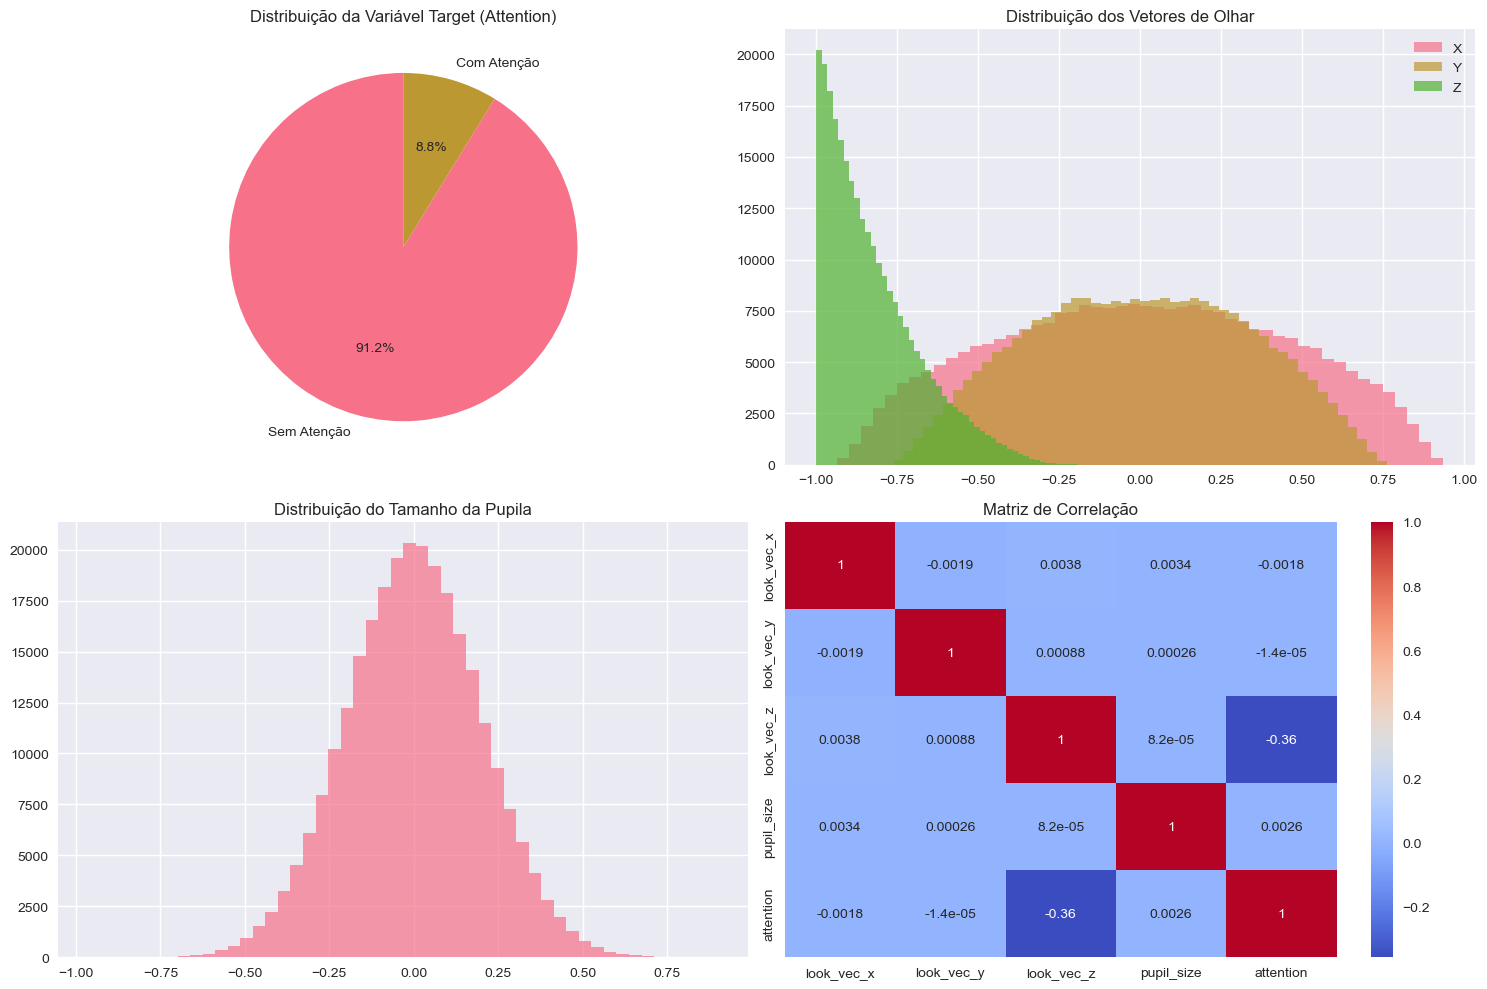

In [9]:
# Exploração dos dados
df = explorar_dados(df)

In [10]:
# Pré-processamento
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocessar_dados(df, sequence_length=10)


=== PRÉ-PROCESSAMENTO DOS DADOS ===
Comprimento da sequência: 10
Dados após remoção de nulos: 272879 registros
Shape das sequências X: (272870, 10, 4)
Shape das sequências y: (272870,)
Shape dos dados de treino: (174636, 10, 4)
Shape dos dados de validação: (43660, 10, 4)
Shape dos dados de teste: (54574, 10, 4)


In [11]:
# Criação do modelo
model = criar_modelo_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))


=== CRIAÇÃO DO MODELO LSTM ===
Input shape: (10, 4)
Número de classes: 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,458 (529.13 KB)

 Trainable params: 134,818 (526.63 KB)

 Non-trainable params: 640 (2.50 KB)

In [12]:
# Treinamento
history = treinar_modelo(model, X_train, y_train, X_val, y_val)


=== TREINAMENTO DO MODELO ===
Epoch 1/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.6492 - loss: 0.6978 - val_accuracy: 0.9108 - val_loss: 0.4797
Epoch 2/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8628 - loss: 0.4378 - val_accuracy: 0.9122 - val_loss: 0.3208
Epoch 3/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9050 - loss: 0.3408 - val_accuracy: 0.9122 - val_loss: 0.2902
Epoch 4/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.9101 - loss: 0.3125 - val_accuracy: 0.9122 - val_loss: 0.2604
Epoch 5/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.9115 - loss: 0.2493 - val_accuracy: 0.9570 - val_loss: 0.1151
Epoch 6/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.9433 - loss: 0.1370 - val_accuracy: 0.9854 - val_loss: 0.0485
Epoch 7/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.9669 - loss: 0.0837 - val_accuracy: 0.9856 - val_loss: 0.0344
Epoch 8/100
1365/1365 ━━━━━━━━━━━━━━━━


=== AVALIAÇÃO DO MODELO ===
1706/1706 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Acurácia no conjunto de teste: 0.9930

Relatório de Classificação:
              precision    recall  f1-score   support

 Sem Atenção       1.00      0.99      1.00     49780
 Com Atenção       0.93      1.00      0.96      4794

    accuracy                           0.99     54574
   macro avg       0.96      1.00      0.98     54574
weighted avg       0.99      0.99      0.99     54574



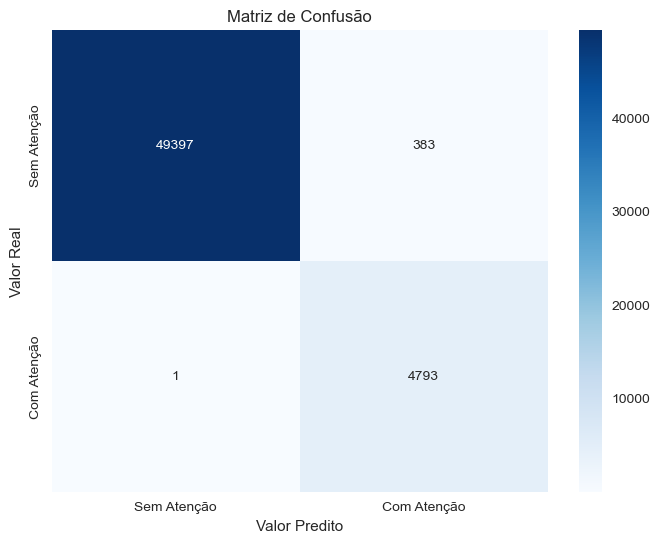

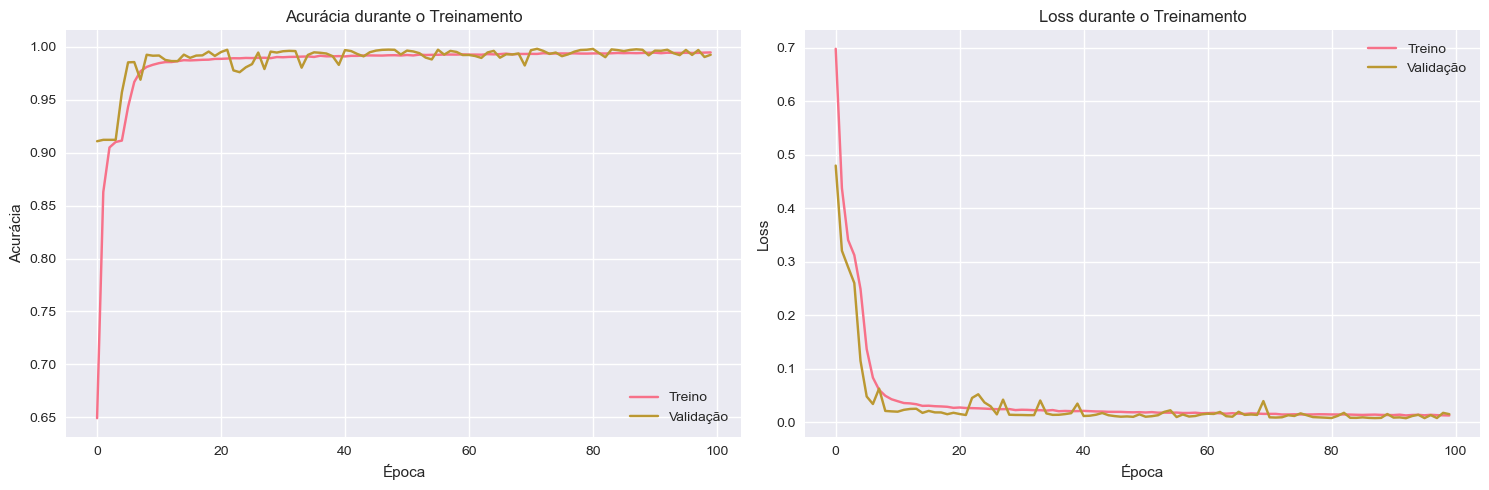

In [13]:
# Avaliação
accuracy, y_pred, y_true = avaliar_modelo(model, X_test, y_test, history)

In [14]:

print(f"\n=== RESUMO FINAL ===")
print(f"Acurácia final no conjunto de teste: {accuracy:.4f}")
print(f"Modelo salvo como: 'melhor_modelo_lstm.h5'")


=== RESUMO FINAL ===
Acurácia final no conjunto de teste: 0.9930
Modelo salvo como: 'melhor_modelo_lstm.h5'
